# Graph Convolutional Network by Kipf and Welling

## Imports

In [1]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

import pickle
import copy
import numpy as np

import itertools

import performance as pf

In [2]:
import os
os.listdir("../data/permutations")

['cora_permutation1.pickle',
 'cora_permutation2.pickle',
 'cora_permutation3.pickle',
 'cora_permutation4.pickle']

## GNN Definition

In [3]:
from GCN import GCN_Net
#import GCN

In [4]:
import importlib
importlib.reload(GCN)

<module 'GCN' from 'C:\\Users\\User\\Documents\\dev\\gnn-community-detection\\Notebooks\\GCN.py'>

## Data Loading

In [4]:
from dgl.data import citation_graph as citegrh
import networkx as nx

data = citegrh.load_cora()
features = th.FloatTensor(data.features)
labels = th.LongTensor(data.labels)
mask = th.BoolTensor(data.train_mask)
g = data.graph

# add self loop
g.remove_edges_from(nx.selfloop_edges(g))
g = DGLGraph(g)
g.add_edges(g.nodes(), g.nodes())

In [50]:
citeseer_data = dgl.data.CitationGraphDataset("citeseer")
citeseer_features = th.FloatTensor(citeseer_data.features)
citeseer_labels = th.LongTensor(citeseer_data.labels)
citeseer_mask = th.BoolTensor(citeseer_data.train_mask)
citeseer_g = citeseer_data.graph

# add self loop
citeseer_g.remove_edges_from(nx.selfloop_edges(citeseer_g))
citeseer_g = DGLGraph(citeseer_g)
citeseer_g.add_edges(citeseer_g.nodes(), citeseer_g.nodes())

C:\Users\a_liso02\AppData\Local\Continuum\anaconda3\lib\site-packages\dgl\data\citation_graph.py:140: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()
Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000


## Select Training, Validation and Test Set

In [5]:
percentage_train = 0.1
percentage_val = 0.1

with open("../data/permutations/cora_permutation1.pickle","rb") as f:
    perm1 = pickle.load(f)
mask_train = np.zeros(g.number_of_nodes())
mask_val = np.zeros(g.number_of_nodes())

i_train = int(percentage_train*g.number_of_nodes())
i_val = i_train + int(percentage_val*g.number_of_nodes())
mask_train[perm1[range(0,i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

In [25]:
features=th.cat([features,th.rand(size=(g.number_of_nodes(),1000))],1)

In [26]:
features.shape

torch.Size([2708, 3433])

In [14]:
features=th.eye(g.number_of_nodes())

## Training

In [6]:
loss_function = pf.perm_inv_loss(labels)

In [8]:
GCN_Net(features.shape[1], 100, len(np.unique(labels)))

TypeError: __init__() missing 4 required positional arguments: 'hidden_layers', 'out_feats', 'dropout', and 'batchnorm'

In [18]:
import time

net = GCN_Net(g, features.shape[1], 100, 2, len(np.unique(labels)), dropout=0.3, batchnorm=True)
#print(net)

optimizer = th.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2)
net.train() # Set to training mode (use dropout)

dur = []
loss_ev = []
current_best = 0 #arbitrarily high
current_best_epoch = 0
current_best_params = None
no_improvement_for = 0

for epoch in range(10000):
    if epoch >=3:
        t0 = time.time()

    # Compute loss for test nodes (only for validation, not used by optimizer)
    net.eval()
    prediction = net(features)
    train_rand=pf.rand_score(labels[mask_train].numpy(),np.argmax(prediction[mask_train].detach().numpy(), axis=1))
    validation_rand=pf.rand_score(labels[mask_val].numpy(),np.argmax(prediction[mask_val].detach().numpy(), axis=1))
    if train_rand>current_best:
        current_best = train_rand
        current_best_epoch = epoch
        current_best_params = copy.deepcopy(net.state_dict())
        no_improvement_for = 0
    else: no_improvement_for += 1
    
    if no_improvement_for>100:
        break
    
    net.train()

    # Compute loss for train nodes
    logits = net(features)

    #loss = loss_function.approximate_loss(logits,mask_train,nclasses=7)
    loss = F.nll_loss(logits[mask_train], labels[mask_train])
    loss_ev.append(loss.detach().item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) {np.mean(dur):.4f}")
    else:
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) unknown")
        
net.load_state_dict(current_best_params)

Epoch 00000 | Loss 2.3277 | Train.Rand 0.0985 | Valid.Rand 0.0855 | Time(s) unknown
Epoch 00001 | Loss 1.9872 | Train.Rand 0.1413 | Valid.Rand 0.1391 | Time(s) unknown
Epoch 00002 | Loss 1.7141 | Train.Rand 0.1984 | Valid.Rand 0.1486 | Time(s) unknown
Epoch 00003 | Loss 1.5509 | Train.Rand 0.2496 | Valid.Rand 0.2207 | Time(s) 0.2499
Epoch 00004 | Loss 1.4093 | Train.Rand 0.2417 | Valid.Rand 0.1845 | Time(s) 0.2744
Epoch 00005 | Loss 1.3042 | Train.Rand 0.2479 | Valid.Rand 0.1972 | Time(s) 0.2697
Epoch 00006 | Loss 1.2575 | Train.Rand 0.3091 | Valid.Rand 0.2908 | Time(s) 0.2609
Epoch 00007 | Loss 1.1989 | Train.Rand 0.3289 | Valid.Rand 0.3114 | Time(s) 0.2587
Epoch 00008 | Loss 1.1849 | Train.Rand 0.3464 | Valid.Rand 0.3204 | Time(s) 0.2546
Epoch 00009 | Loss 1.1668 | Train.Rand 0.3886 | Valid.Rand 0.3273 | Time(s) 0.2540
Epoch 00010 | Loss 1.1203 | Train.Rand 0.4155 | Valid.Rand 0.3353 | Time(s) 0.2535
Epoch 00011 | Loss 1.1237 | Train.Rand 0.4337 | Valid.Rand 0.3478 | Time(s) 0.2513
E

Epoch 00098 | Loss 0.3567 | Train.Rand 0.9345 | Valid.Rand 0.4300 | Time(s) 0.2527
Epoch 00099 | Loss 0.3465 | Train.Rand 0.9145 | Valid.Rand 0.3835 | Time(s) 0.2533
Epoch 00100 | Loss 0.3346 | Train.Rand 0.9102 | Valid.Rand 0.3717 | Time(s) 0.2534
Epoch 00101 | Loss 0.3294 | Train.Rand 0.9193 | Valid.Rand 0.4327 | Time(s) 0.2535
Epoch 00102 | Loss 0.3303 | Train.Rand 0.9151 | Valid.Rand 0.4544 | Time(s) 0.2536
Epoch 00103 | Loss 0.3415 | Train.Rand 0.9056 | Valid.Rand 0.4676 | Time(s) 0.2536
Epoch 00104 | Loss 0.3345 | Train.Rand 0.9236 | Valid.Rand 0.4472 | Time(s) 0.2537
Epoch 00105 | Loss 0.3313 | Train.Rand 0.9340 | Valid.Rand 0.4342 | Time(s) 0.2538
Epoch 00106 | Loss 0.3310 | Train.Rand 0.9450 | Valid.Rand 0.4353 | Time(s) 0.2537
Epoch 00107 | Loss 0.3570 | Train.Rand 0.9345 | Valid.Rand 0.4135 | Time(s) 0.2537
Epoch 00108 | Loss 0.3637 | Train.Rand 0.9436 | Valid.Rand 0.3979 | Time(s) 0.2538
Epoch 00109 | Loss 0.3559 | Train.Rand 0.9547 | Valid.Rand 0.3974 | Time(s) 0.2539
Epoc

KeyboardInterrupt: 

In [19]:
net.load_state_dict(current_best_params)

<All keys matched successfully>

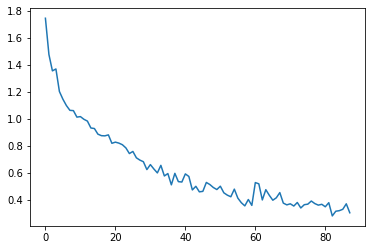

In [11]:
import seaborn as sns
sns.lineplot(x=range(len(loss_ev)), y=loss_ev)

## Evaluation

In [21]:
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = current_best_model(features).detach()
pf.performance_as_df(labels,final_prediction,mask)

,All,Train,Test
Rand-Index,0.463977,0.537447,0.460643
Mutual Information,0.450004,0.552992,0.446484
Variation of Information,1.981282,1.467513,1.991336
